In [1]:
import sys, os, copy, re, pathlib
from natsort import natsorted
import pandas as pd
import seaborn as sns
import FlowCal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [3]:
# Convert row letter to integer,
# for indicating replicates:
letter2rep = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 1, 'F': 2, 'G': 3, 'H': 4}
letter2row = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}

In [4]:
# Read sample annotations:
sample_anno = pd.read_excel('sample_annotations.xlsx')
sample_anno['Plate'] = [v.upper() for v in sample_anno['Plate'].values]
# Define the offset on the 96 well format (rows, columns):
plate_offset = {'P1': (0, 0), 'P2': (0, 6), 'P3': (4, 0), 'P4': (0, 0), 'P5': (0, 6), 'P6': (4, 0)}
# Flow samples were made from the 01-13-22_low batch:
folder = '01-13-22_low'
sample_mask = sample_anno['Folder'] == folder
sample_anno[sample_mask]

,Cell_line,Folder,Plate,Time_first_mes,Timepoints,Gradient,Unit,Drug,Rescue,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6
35,HT1080-WT_ATF4-rep,01-13-22_low,P1,18.0,False,False,NaN,Vehicle,NaN,Vehicle,Asn,SM,Asp,Pyr,aKB
36,HT1080-WT_ATF4-rep,01-13-22_low,P2,18.0,False,False,NaN,Rotenone,NaN,Vehicle,Asn,SM,Asp,Pyr,aKB
37,HT1080-WT_ATF4-rep,01-13-22_low,P3,18.0,False,False,NaN,Antimycin,NaN,Vehicle,Asn,SM,Asp,Pyr,aKB
38,HT1080-WT_ATF4-rep,01-13-22_low,P4,18.0,False,False,NaN,Oligomycin,NaN,Vehicle,Asn,SM,Asp,Pyr,aKB
39,HT1080-WT_ATF4-rep,01-13-22_low,P5,18.0,False,False,NaN,FCCP,NaN,Vehicle,Asn,SM,Asp,Pyr,aKB
40,HT1080-WT_ATF4-rep,01-13-22_low,P6,18.0,False,False,NaN,Mix,NaN,Vehicle,Rot,Atp,Atp+Rot,Atp+Asn,Atp+Asp


In [5]:
# Locate FCS files:
cur_dir = pathlib.Path('.')
fcs_paths = list(cur_dir.glob('flow_data/Unmixed/*/P?/*.fcs'))

well_names = list()
for fp in fcs_paths:
    fp = str(fp)
    well_names.append('-'.join(fp.split('/')[-2:]).split(' ')[0])

In [6]:
# Read FCS files into object and apply gates:
fcs = [FlowCal.io.FCSData(str(fp)) for fp in fcs_paths]
# Gate for minimum forward and side scatter:
fcs_g = [FlowCal.gate.high_low(di, channels=['FSC-A', 'FSC-H'], low=300000) for di in fcs]
fcs_g = [FlowCal.gate.high_low(di, channels='SSC-A', low=200000) for di in fcs_g]
print('Done, minimum FSC/SSC.')
# Gate for single cells using side scatter:
fcs_g = [FlowCal.gate.density2d(di, channels=['SSC-A', 'SSC-H'], gate_fraction=0.92) for di in fcs_g]
print('Done, single cell side scatter.')
# Gate for single cells using forward scatter:
fcs_g = [FlowCal.gate.density2d(di, channels=['FSC-A', 'FSC-H'], gate_fraction=0.92) for di in fcs_g]
print('Done, single cell forward scatter.')
# Gate for uniform population as per forward and side scatter:
fcs_g = [FlowCal.gate.density2d(di, channels=['FSC-A', 'SSC-A'], gate_fraction=0.92) for di in fcs_g]
print('Done, uniform forward and side scatter population.')

Done, minimum FSC/SSC.
Done, single cell side scatter.
Done, single cell forward scatter.
Done, uniform forward and side scatter population.


In [7]:
# Plot gating of each sample:
for idx, fcs_i in enumerate(fcs_g):
    N_no_gate = len(fcs[idx])
    N_gate = len(fcs_i)
    title = 'Retained: {} %'.format(round(N_gate / N_no_gate * 100))
    FlowCal.plot.density_and_hist(fcs_i, density_channels=['FSC-A', 'SSC-A'], density_params={'mode':'scatter', 'title': title}, hist_channels=['RFP-A'], savefig='_plots/after_gating/{}.pdf'.format(well_names[idx]))

In [8]:
### Read flow data into dataframe ###
data_fl = pd.DataFrame(columns=['Folder', 'Plate', 'Drug', 'Rescue', 'Replicate', 'RFP_f1', 'RFP_f2', 'RFP_f3', 'RFP_f4', 'RFP_f5'])
for idx, di in enumerate(fcs_g):
    af = di[:,['AF-A']] # Autofluorescence
    rfp = di[:,['RFP-A']] # RFP signal
    # There can be multiple ways for calculating the average cell RFP
    rfp_1 = rfp.mean() # Raw RFP
    rfp_af = rfp - af
    rfp_2 = rfp_af.mean() # RFP minus autofluorescence
    rfp_af_min = rfp_af - rfp_af.min()
    rfp_3 = rfp_af_min.mean() # RFP minus autofluorescence, baseline adjusted to positive values
    mask_pos = rfp_af > 0
    mask_neg = rfp_af < 0
    rfp_4 = rfp_af[mask_pos].mean() # RFP minus autofluorescence, only positive values
    rfp_af_zero = copy.deepcopy(rfp_af)
    rfp_af_zero[mask_neg] = 0
    rfp_5 = rfp_af_zero.mean() # RFP minus autofluorescence, negative values adjusted to zero

    # Add data to row in dataframe:
    plate, well = well_names[idx].split('-')
    replicate = letter2rep[well[0]]
    col_idx = int(well[1:]) - plate_offset[plate][1]
    col = 'Col {}'.format(col_idx)
    mask = (sample_anno['Folder'] == folder) & (sample_anno['Plate'] == plate)
    drug = sample_anno.loc[mask, 'Drug'].values[0]
    rescue = sample_anno.loc[mask, col].values[0]
    data_list = [folder, plate, drug, rescue, replicate, rfp_1, rfp_2, rfp_3, rfp_4, rfp_5]
    data_fl.loc[idx, :] = data_list

In [9]:
data_fl

,Folder,Plate,Drug,Rescue,Replicate,RFP_f1,RFP_f2,RFP_f3,RFP_f4,RFP_f5
0,01-13-22_low,P3,Antimycin,Vehicle,3,45021.121094,6163.371094,304353.5,16326.474609,10405.65625
1,01-13-22_low,P3,Antimycin,aKB,1,47859.464844,-948.019104,138758.65625,13160.193359,5874.163086
2,01-13-22_low,P3,Antimycin,Pyr,2,50109.695312,1927.225952,176300.875,15505.685547,7957.421387
3,01-13-22_low,P3,Antimycin,Vehicle,2,45576.953125,7574.200195,299821.71875,16978.421875,11277.551758
4,01-13-22_low,P3,Antimycin,aKB,3,47863.828125,-892.048706,193681.390625,12958.803711,5793.169434
...,...,...,...,...,...,...,...,...,...,...
139,01-13-22_low,P6,Mix,Rot,1,52716.707031,15074.275391,967318.625,19008.068359,16334.381836
140,01-13-22_low,P6,Mix,Atp+Asn,3,65715.570312,25761.662109,130793.015625,28481.712891,26457.318359
141,01-13-22_low,P6,Mix,Rot,2,65079.613281,42607.472656,82346.210938,43132.265625,42672.3125
142,01-13-22_low,P6,Mix,Atp+Asn,1,64944.457031,26858.878906,646655.875,29704.757812,27568.148438


In [10]:
### Read IncuCyte data ###
data_IC = pd.DataFrame(columns=['Folder', 'Plate', 'Drug', 'Rescue', 'Replicate', 'RFP_IC'])
row_idx = 0
cell_line_folder = 'HT1080-WT_ATF4-rep'
home_p = pathlib.Path('IC_data/{}'.format(cell_line_folder))
for fnam in natsorted(home_p.glob('{}/*.txt'.format(folder))):
    plate = str(fnam).split('/')[-1][:-4]
    plate = plate.upper()
    tmp_df = pd.read_csv(fnam, skiprows=1, sep='\t')
    # Notice the last timepoint is chosen:
    for colnam, val in zip(tmp_df.columns, tmp_df.loc[len(tmp_df)-1].values):
        if colnam[0] in 'ABCD' and colnam[1] in '123456':
            pass
        else:
            continue

        rep = letter2rep[colnam[0]]
        col = 'Col {}'.format(colnam[1])
        mask = (sample_anno['Folder'] == folder) & (sample_anno['Plate'] == plate)
        drug = sample_anno.loc[mask, 'Drug'].values[0]
        rescue = sample_anno.loc[mask, col].values[0]
        data_list = [folder, plate, drug, rescue, rep, val]
        data_IC.loc[row_idx, :] = data_list
        row_idx += 1

In [11]:
data_IC

,Folder,Plate,Drug,Rescue,Replicate,RFP_IC
0,01-13-22_low,P1,Vehicle,Vehicle,1,1707118
1,01-13-22_low,P1,Vehicle,Vehicle,2,1972226
2,01-13-22_low,P1,Vehicle,Vehicle,3,2214697
3,01-13-22_low,P1,Vehicle,Vehicle,4,1850008
4,01-13-22_low,P1,Vehicle,Asn,1,2521753
...,...,...,...,...,...,...
138,01-13-22_low,P6,Mix,Atp+Asn,4,4045354
139,01-13-22_low,P6,Mix,Atp+Asp,1,1866304
140,01-13-22_low,P6,Mix,Atp+Asp,2,2351615
141,01-13-22_low,P6,Mix,Atp+Asp,3,3025973


In [22]:
# Merge dataframe:
data_merged = data_IC.merge(data_fl, on=['Folder', 'Plate', 'Drug', 'Rescue','Replicate'])
data_merged = data_merged.astype({'RFP_IC': 'float', 'RFP_f1': 'float', 'RFP_f2': 'float', 'RFP_f3': 'float', 'RFP_f4': 'float', 'RFP_f5': 'float'})

In [23]:
# Let's look at the correlation between flow and IncuCyte data:
x = data_merged['RFP_IC'].values.astype(float)
for i in range(5):
    y = data_merged['RFP_f{}'.format(i+1)].values
    cor = np.corrcoef(x, y)[0][1]
    print('Correlation: RFP_f{} -> {:.2}'.format(i+1, cor))

Correlation: RFP_f1 -> 0.2
Correlation: RFP_f2 -> 0.69
Correlation: RFP_f3 -> -0.021
Correlation: RFP_f4 -> 0.77
Correlation: RFP_f5 -> 0.74


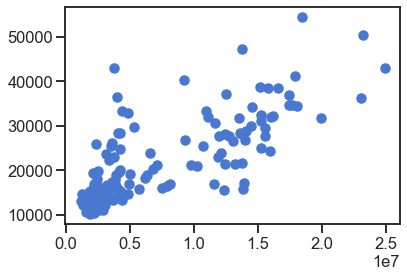

In [24]:
# RFP_f4 is highly correlated:
flow_RFP = 'RFP_f4'
y = data_merged[flow_RFP].values
plt.scatter(x, y)
# plt.xscale('log')
# plt.yscale('log')

In [38]:
# Maybe the correlation increases by taking
# the average of the replicates:
data_merged_mean = data_merged.groupby(['Folder', 'Plate', 'Drug', 'Rescue']).mean().reset_index()
x = data_merged_mean['RFP_IC'].values.astype(float)
for i in range(5):
    y = data_merged_mean['RFP_f{}'.format(i+1)].values
    cor = np.corrcoef(x, y)[0][1]
    print('Correlation: RFP_f{} -> {:.2}'.format(i+1, cor))

Correlation: RFP_f1 -> 0.2
Correlation: RFP_f2 -> 0.72
Correlation: RFP_f3 -> -0.036
Correlation: RFP_f4 -> 0.84
Correlation: RFP_f5 -> 0.79


<ipython-input-38-d0fd6fcf0768>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_merged_mean = data_merged.groupby(['Folder', 'Plate', 'Drug', 'Rescue']).mean().reset_index()


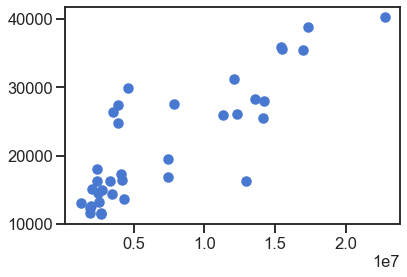

In [39]:
# The correlation to RFP_f4 looks pretty good:
flow_RFP = 'RFP_f4'
y = data_merged_mean[flow_RFP].values
plt.scatter(x, y)
# plt.xscale('log')
# plt.yscale('log')

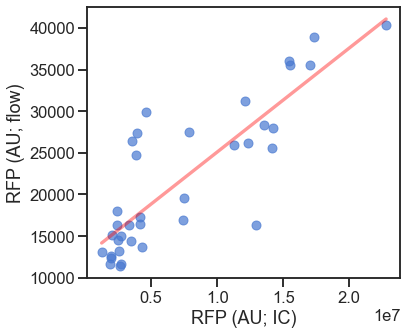

In [44]:

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
g1 = sns.regplot(ax=ax1, x=x, y=y, scatter_kws=dict(alpha=0.7), \
                 ci=None, line_kws=dict(color='red', alpha=0.4))

g1.set_ylabel('RFP (AU; flow)');
g1.set_xlabel('RFP (AU; IC)');

fig.tight_layout()
fig.savefig('plots/corr.pdf')

<ipython-input-17-5da575a35e37>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Drug', y='RFP_IC', hue='Rescue', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)


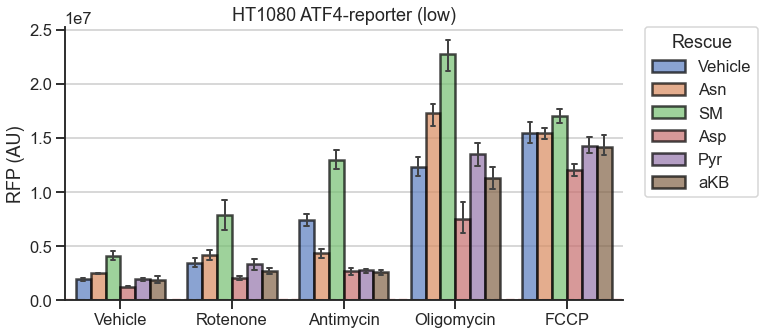

In [17]:
### Plot IncuCyte results ###
fig, ax1 = plt.subplots(1, 1, figsize=(11, 5))
mask = (data_merged['Folder'] == folder) & (data_merged['Drug'] != 'Mix')
g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Drug', y='RFP_IC', hue='Rescue', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
ax1.axhline(y=1, color='r', linestyle='--', zorder=0)

g1.set_ylabel('RFP (AU)')
g1.set_xlabel('')
g1.set_title('HT1080 ATF4-reporter (low)')
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Rescue')

sns.despine()
fig.tight_layout()
fig.savefig('plots/IncuCyte_mito-inhib.pdf', bbox_inches='tight')

<ipython-input-18-66008db8839e>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Drug', y='RFP_f4', hue='Rescue', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)


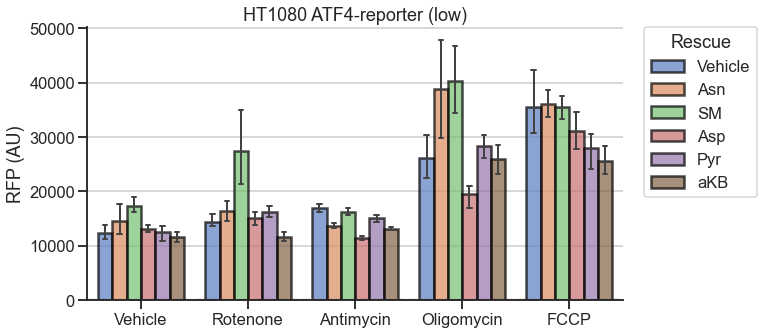

In [18]:
### Plot flow results ###
fig, ax1 = plt.subplots(1, 1, figsize=(11, 5))
mask = (data_merged['Folder'] == folder) & (data_merged['Drug'] != 'Mix')
g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Drug', y='RFP_f4', hue='Rescue', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
ax1.axhline(y=1, color='r', linestyle='--', zorder=0)

g1.set_ylabel('RFP (AU)')
g1.set_xlabel('')
g1.set_title('HT1080 ATF4-reporter (low)')
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Rescue')

sns.despine()
fig.tight_layout()
fig.savefig('plots/flow_mito-inhib.pdf', bbox_inches='tight')

<ipython-input-19-808dee5a3260>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Rescue', y='RFP_IC', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)


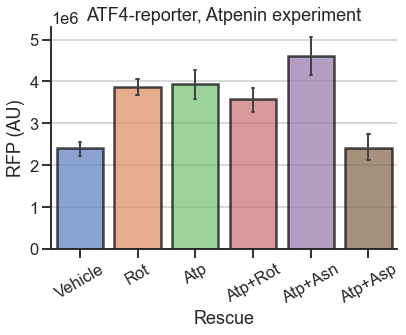

In [19]:
### Plot Atpenin data - IncuCyte ###
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
mask = (data_merged['Drug'] == 'Mix')
g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Rescue', y='RFP_IC', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)

g1.set_ylabel('RFP (AU)')
g1.set_title('ATF4-reporter, Atpenin experiment')
g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
g1.grid(True, axis='y')

sns.despine()
fig.tight_layout()
fig.savefig('plots/IncuCyte_Atp-exp.pdf', bbox_inches='tight')

<ipython-input-20-848170c6ea8d>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Rescue', y='RFP_f4', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)


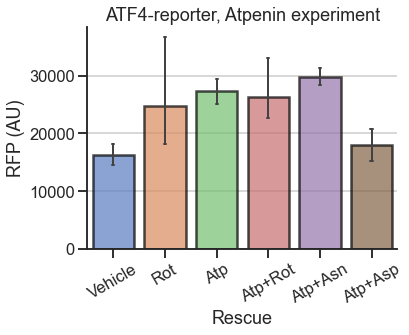

In [20]:
### Plot Atpenin data - flow ###
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
mask = (data_merged['Drug'] == 'Mix')
g1 = sns.barplot(ax=ax1, data=data_merged[mask], x='Rescue', y='RFP_f4', ci=90, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)

g1.set_ylabel('RFP (AU)')
g1.set_title('ATF4-reporter, Atpenin experiment')
g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
g1.grid(True, axis='y')

sns.despine()
fig.tight_layout()
fig.savefig('plots/flow_Atp-exp.pdf', bbox_inches='tight')